# Models and Evaluation
**Kaggle Competition:** House Prices: Advanced Regression Techniques

Saloni Sharma

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import statsmodels.formula.api as smf

from sklearn import metrics
from sklearn.linear_model import LinearRegression

In [2]:
# load data
train = pd.read_csv("CleanTransformedTrain.csv")
test = pd.read_csv("CleanTransformedTest.csv")
# remove later
sample = pd.read_csv("house-prices-advanced-regression-techniques/sample_submission.csv")


## 1. Pick Features

#### 1.a. View possible features to use based on correlation with SalePrice.

In [3]:
# correltation of SalePrice with all numerical features
train.corr()["SalePrice"].sort_values(ascending=False).head(15)

SalePrice           1.000000
OverallQual         0.790982
GrLivArea           0.708624
Neighborhood_Num    0.666890
GarageCars          0.640409
GarageArea          0.623431
TotalBsmtSF         0.613581
1stFlrSF            0.605852
FullBath            0.560664
TotRmsAbvGrd        0.533723
YearBuilt           0.522897
YearRemodAdd        0.507101
GarageYrBlt         0.500237
MasVnrArea          0.472614
Fireplaces          0.466929
Name: SalePrice, dtype: float64

From above, we can see that the top 5 features based on correlation are: 
1. OverallQual
2. GrLivArea
3. Neighborhood_Num
4. GarageCars
5. TotalBsmtSF

(Note: I am ignoring GarageArea since it provides very similar information to GarageCars and has a lower correlation.)

I will create and evaluate models with varying combinations of the the top 5 along with the other highly correlated features.

#### 1.b. Simple Linear Regression Models
I will plot regression models with the most correlated features and compare their R^2 values.

R-Squared: 0.625651892462118


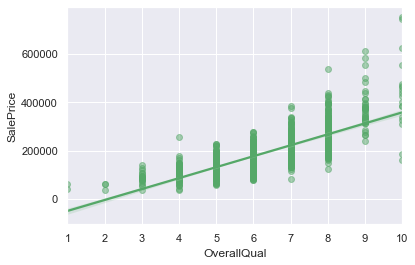

In [4]:
# OverallQual
model_OverallQual = smf.ols(formula="SalePrice ~ OverallQual", data=train).fit()
print("R-Squared:", model_OverallQual.rsquared)
sns.regplot(x=train.OverallQual, y=train.SalePrice, data=train, ci=95, color="g",  scatter_kws={'alpha':0.5});

R-Squared: 0.5021486502718042


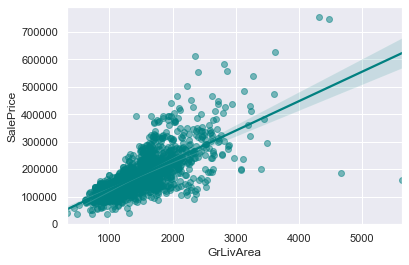

In [5]:
# GrLivArea
model_GrLivArea = smf.ols(formula="SalePrice ~ GrLivArea", data=train).fit()
print("R-Squared:", model_GrLivArea.rsquared)
sns.regplot(x=train.GrLivArea, y=train.SalePrice, data=train, ci=95, color="teal",  scatter_kws={'alpha':0.5});

R-Squared: 0.4447420328089706


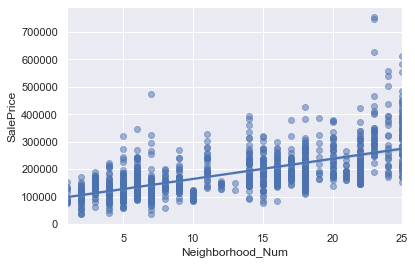

In [6]:
# Neighborhood_Num
model_Neighborhood_Num = smf.ols(formula="SalePrice ~ Neighborhood_Num", data=train).fit()
print("R-Squared:", model_Neighborhood_Num.rsquared)
sns.regplot(x=train.Neighborhood_Num, y=train.SalePrice, data=train, ci=95, color="b",  scatter_kws={'alpha':0.5});

The R^2 values for these models are not very high. So, we will continue on to multilinear models next.

## 2. Regression Model without Interactions
This method below will show a model with the highest R^2 value, but without any interactions, which we will look at in the following section. I will use this method to check for other features that may not have a high correlation, but still have an affect on SalePrice.

#### 2.a. Forward Stepwise Refinement
Create a function to perform this process.

In [7]:
# this function with perform the forward stepwise selection process

def forward_stepwise(k, data, factors, Mk_1):
    # 1. Set up a reg. model with k features/factors 
    # Mk_1 is the model for k-1 factors
    
    #2. Try all predictors in the new kth position
    models = []
    for factor in factors:
        formula_str = "SalePrice ~ " + Mk_1 + "+" + str(factor)
        Mk = smf.ols(formula=formula_str, data=data).fit()
        models.append(Mk)
    
    #3. select feature based on highest R^2 for each model
    models_R2 = list(map(lambda m:m.rsquared, models))
    #find index of model with highest R^2
    Mk_idx = models_R2.index( max(models_R2) )
    
    #print("Rsquared is", max(models_R2))
    
    #4. Add the newly chosen feature and continue to next loop for k+1
    new_predictor = factors[Mk_idx]
    
    # return string of best predictors
    if Mk_1 == "":
        formula_kfactors = str(new_predictor)
    else:
        formula_kfactors = Mk_1 + " + " + str(new_predictor)
    
    return formula_kfactors

#### 2.b. Prepare dataframe

In [8]:
# the smf.ols formula does not accept column names that start with numbers
start_with_num = {'1stFlrSF': 'FirstFlrSF', '2ndFlrSF': 'SecondFlrSF', '3SsnPorch': 'ThreeSsnPorch'}
# rename those columns
train.rename(columns=start_with_num, inplace=True)

# all numerical features
factors = list(train.corr().index.drop(['Id', 'SalePrice'])) # all columns except 'Id'

#### 2.c. Perform forward stepwise selection of features.

In [9]:
Mk_1 = "" # start with empty model
for k in range(1,11):
    Mk_1 = forward_stepwise(k, train, factors, Mk_1)
print("Multilinear Model with 10 features:\n\n" + Mk_1)

Multilinear Model with 10 features:

OverallQual + GrLivArea + BsmtFinSF1 + Neighborhood_Num + MSSubClass + GarageCars + OverallCond + MasVnrArea + BsmtFullBath + BedroomAbvGr


In [10]:
print("This model has an r-squared value of", smf.ols(formula="SalePrice ~"+Mk_1, data=train).fit().rsquared)

This model has an r-squared value of 0.8087725742984802


This r-squared value is considerably better than the previous simple regression models. However, we can still improve this by adding interactions.

## 3. Model: Multivariate Linear Regression
I will create the final model using features that have high correlation from 1.a. and resulted in a high R^2 value in 2.c. to create interactions that can better predict SalePrice.

#### 3.a. Model with Stepwise Features Combined
This model will include all the features that were in the result of forward stepwise regression, and I will create all of the possible combinations of interactions in the model.

In [11]:
# create full interactions with all features from stepwise selection in 2.c.
print(Mk_1)

OverallQual + GrLivArea + BsmtFinSF1 + Neighborhood_Num + MSSubClass + GarageCars + OverallCond + MasVnrArea + BsmtFullBath + BedroomAbvGr


In [12]:
model_stepwise_inter = smf.ols(formula="SalePrice ~ OverallQual*GrLivArea*Neighborhood_Num*BsmtFinSF1*MSSubClass*GarageCars*BedroomAbvGr*OverallCond*MasVnrArea*BsmtFullBath", data=train).fit()
#model.summary()
print("R-Squared:", model_stepwise_inter.rsquared)

R-Squared: 0.9722184766786998


This model has a very high R^2 value, meaning these features do have a significant impact on predicting the SalePrice.

We can view the p-values for the interactions from the model. A higher value indicates that the null hypothesis is true, and there is evidence of a relationship between the features, meaning there may be multicollinearity occurring.

In [13]:
# highest p-values for stepwise interactions model
model_stepwise_inter.pvalues.sort_values().tail()

OverallQual:GrLivArea:BsmtFinSF1:MSSubClass:MasVnrArea                                0.993646
OverallQual:BsmtFinSF1:MSSubClass:BedroomAbvGr:OverallCond:MasVnrArea:BsmtFullBath    0.994126
Neighborhood_Num:MSSubClass:GarageCars:MasVnrArea                                     0.998845
BsmtFinSF1:GarageCars:BedroomAbvGr:OverallCond                                        0.999152
GarageCars:OverallCond:MasVnrArea                                                     0.999936
dtype: float64

#### 3.b. Model with Highly-Correlated Features Combined
This model will include all the features that are highly correlated with SalePrice, and all of the possible combinations of interactions as well.

In [14]:
# create full interactions with 10 features highly correlated from 1.a.
# list of top 10 features:
train.corr()["SalePrice"].sort_values(ascending=False).index[:12].drop(['SalePrice'])

Index(['OverallQual', 'GrLivArea', 'Neighborhood_Num', 'GarageCars',
       'GarageArea', 'TotalBsmtSF', 'FirstFlrSF', 'FullBath', 'TotRmsAbvGrd',
       'YearBuilt', 'YearRemodAdd'],
      dtype='object')

In [15]:
model_corr_inter = smf.ols(formula="SalePrice ~ OverallQual*GrLivArea*Neighborhood_Num*GarageCars*TotalBsmtSF*FirstFlrSF*FullBath*TotRmsAbvGrd*YearBuilt*YearRemodAdd", data=train).fit()
#model.summary()
print("R-Squared:", model_corr_inter.rsquared)

R-Squared: 0.9463956674182005


In [16]:
# highest p-values for stepwise interactions model
model_corr_inter.pvalues.sort_values().tail()

Neighborhood_Num:FullBath:TotRmsAbvGrd                                                                         0.996998
OverallQual:Neighborhood_Num:GarageCars:TotalBsmtSF:FirstFlrSF:FullBath:TotRmsAbvGrd:YearBuilt:YearRemodAdd    0.997559
GarageCars:TotalBsmtSF:FullBath:TotRmsAbvGrd:YearBuilt                                                         0.998658
OverallQual:GarageCars                                                                                         0.999242
OverallQual:TotalBsmtSF:FirstFlrSF:YearBuilt                                                                   0.999289
dtype: float64

The combination of features from the forward stepwise selection have a higher R^2 than the highly correlated features combined. Both models have certain interactions with extremely high p-values.

#### 3.c. Final Multilinear Regression Model
I will create a new model using the features that appear in both, and then comparing combinations of the features that only appear in one of them. While doing so, I will try to minimize the p-values and maintain a high R^2 value.

In [17]:
# view lowest p-values for stepwise interactions model
model_stepwise_inter.pvalues.sort_values().head()
# these interactions will be useful to include in this model

Intercept                                                                   0.000014
MSSubClass:GarageCars:BedroomAbvGr:OverallCond                              0.000271
OverallQual:GrLivArea:MSSubClass:GarageCars:BedroomAbvGr                    0.000358
OverallQual:GrLivArea:MSSubClass:GarageCars                                 0.000395
OverallQual:GrLivArea:Neighborhood_Num:MSSubClass:GarageCars:OverallCond    0.000464
dtype: float64

In [18]:
#  multilinear model with interactions
model_str = """SalePrice ~ 
OverallQual*GrLivArea*BsmtFinSF1*YearRemodAdd
+ Neighborhood_Num*GarageCars*TotalBsmtSF*TotRmsAbvGrd*YearBuilt
+ GrLivArea*GarageCars + MSSubClass + BedroomAbvGr 
+ BsmtFullBath + OverallCond*Fireplaces
"""
model = smf.ols(formula=model_str, data=train).fit()
#model2.summary()
print("R-Squared:", model.rsquared)

R-Squared: 0.9244266635802814


In [19]:
# highest p-values in model
model.pvalues.sort_values().tail()

Neighborhood_Num:GarageCars:TotRmsAbvGrd    0.027420
Neighborhood_Num:TotRmsAbvGrd:YearBuilt     0.029065
Neighborhood_Num:TotRmsAbvGrd               0.033774
YearRemodAdd                                0.041100
BedroomAbvGr                                0.081955
dtype: float64

The R^2 has dropped a bit compared to the first stepwise model. However, we have been able to get p-values less than 0.05 for all interactions and most individual features.

#### 3.d. Further Evaluation
I will use a few more metrics to further evaluate the results of the predictions.

In [20]:
# train model and predict results
train_pred = model.predict(train)

These error measurements are additional measures of accuracy for the model. 
- MAE (Mean Absolute Error): average error
- MSE (Mean Squared Error): average of squared errors
- RMSE (Root Mean Squared Error): square root of MSE

In [21]:
# Calculate and print values of MAE, MSE, RMSE
print('MAE:', metrics.mean_absolute_error(train.SalePrice, train_pred))  
print('MSE:', metrics.mean_squared_error(train.SalePrice, train_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(train.SalePrice, train_pred)))

MAE: 15339.493208677472
MSE: 476625055.4886443
RMSE: 21831.744215445644


In [22]:
model_R2 = metrics.r2_score(train.SalePrice, train_pred)
print('R-Squared:', model_R2)

R-Squared: 0.9244266635802814


Finally, the model is complete and I will apply this to the test data.

## 4. Predictive Model for Test Data
We are ready to apply the multivariate model to the test data to make predictions.

#### 4.a. Predict SalePrice based on test data.

In [23]:
# predict SalePrice using trained model
test_pred = model.predict(test)

In [24]:
# check the results
print("Average price:", np.mean(test_pred))
print("Min price:", np.min(test_pred))
print("Max price:", np.max(test_pred))
print("Median price:", np.median(test_pred))

Average price: 177483.27026610562
Min price: -883713.0568881016
Max price: 567775.2752405982
Median price: 159229.16818608716


This is a similar average to the data in the training set, where the average was $180,921.

That's interesting that some prices were predicted as large negative values. Let's see how many prices are below zero.

In [25]:
# negative prices
test_pred[test_pred<0]

362      -4204.700539
1089   -883713.056888
dtype: float64

In [26]:
# replace negative values by median of all predictions
test_pred[362] = np.median(test_pred)
test_pred[1089] = np.median(test_pred)

In [27]:
# this should now be empty
test_pred[test_pred<0]

Series([], dtype: float64)

In [28]:
# re-view stats about results
print("Average price:", np.mean(test_pred))
print("Min price:", np.min(test_pred))
print("Max price:", np.max(test_pred))
print("Median price:", np.median(test_pred))

Average price: 178310.1215983878
Min price: 17178.937971243635
Max price: 567775.2752405982
Median price: 159229.16818608716


#### 4.b. Save predicted results.
The predicted prices are now complete and can be saved into the submission file for the competition.

In [29]:
# create new data frame from prices
df_pred = pd.DataFrame(test_pred, columns=['SalePrice'])

# add column for 'Id'
df_pred['Id'] = test['Id']

# reorder the columns
df_pred = df_pred[['Id', 'SalePrice']]

In [30]:
df_pred.head()

,Id,SalePrice
0,1461,117378.270664
1,1462,143790.851878
2,1463,175725.608103
3,1464,194738.619011
4,1465,183703.265761


In [34]:
# create submission file
df_pred.to_csv("SS_submission.csv", index=False)

## 5. Conclusion

Although we can't check the results directly. I thought it would interesting to compare the results with the prices from the training data set.

In [32]:
# Calculate and view values of MAE, MSE, RMSE

# For better comparison, sort prices to be in ascending order
train_SalePrice = train.SalePrice.sort_values()[1:]
test_SalePrice = test_pred.sort_values()

print("Comparison to Train SalePrices:")
print('MAE:', metrics.mean_absolute_error(train_SalePrice, test_SalePrice))  
print('MSE:', metrics.mean_squared_error(train_SalePrice, test_SalePrice))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(train_SalePrice, test_SalePrice)))

print('\nTrain & Test R-Squared:', metrics.r2_score(train_SalePrice, test_SalePrice))

Comparison to Train SalePrices:
MAE: 3372.7271826190376
MSE: 82967561.47823945
RMSE: 9108.653109995981

Train & Test R-Squared: 0.9868231981581304


The error measures are smaller than the results of the training set. This has a very high p-value, which only indicates that the results are similar to the training set. But, it may be different from the actual prices for the test data.

The plot below shows the distribution of the predicted values. It looks very similar to the plot of the training data.

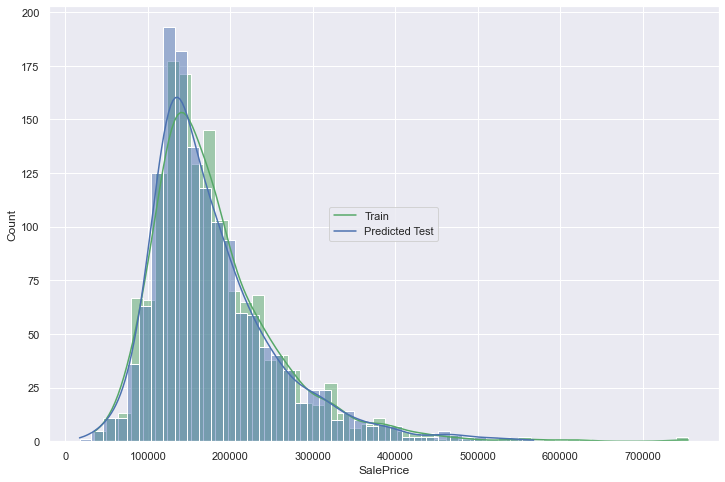

In [52]:
plt.figure(figsize=(12,8))
plt.xlabel("SalePrice")
sns.histplot(train.SalePrice, kde=True, color='g');
sns.histplot(test_pred, kde=True);
plt.legend(labels=["Train", "Predicted Test"], loc='center');